# TensorFlow 패키지 소개

TensorFlow 패키지는 Theano 패키지와 마찬가지로 선형 대수 심볼 컴파일러(Symbolic Linear Algebra Compiler)이다. Theano에 비해 분산처리(distributed computing) 기능 등이 강화되어 있다. 여기에서는 버전 1.13을 사용한다.

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # warning 출력 방지
tf.__version__

'1.15.0'

## TensorFlow 기본 사용법

Theano와 유사하게 TensorFlow도 다음과 같은 과정을 거쳐 사용한다.

1. 텐서 정의
2. 텐서 연산 정의
3. 세션 정의
4. 세션 사용

세션(Session)은 Theano의 함수와 유사한 역할을 하며 실제 심볼 변수의 관계를 분석하고 값을 계산해준다. 

## 그래프와 세션

TensorFlow은 모든 연산을 자체적으로 CPU에서 하는게 아니라 외부(다른 컴퓨터)에 분산되어있는(distributed) GPU에서 처리한다고 가정한다. 따라서 변수의 값을 할당하는 아주 간단한 연산부터 복잡한 선형대수연산까지 프로그램이 돌아가는 컴퓨터 자체 내에서 이루어지는 것은 없다. 

TensorFlow에서 텐서(Tensor) 계산 과정은 모두 **그래프(Graph)**라고 부르는 객체 내에 저장된다. 그래프를 계산하려면 외부 컴퓨터에 이 그래프 정보를 전달하고 그 결과값을 받아야 한다. 그 통신과정을 담당하는 것이 **세션(Session)**이라고 부르는 객체이다. 

따라서 모든 텐서 계산은 해당하는 텐서를 포함하는 그래프를 세션 객체에 전달하여 원격 실행한 후에야 값을 볼 수 있다. 변수에 상수를 할당하는 아주 간단한 연산조차도 마찬가지이다. 
일관성을 위해 이러한 과정은 GPU를 사용하지 않거나 분산처리를 하지 않더라도 동일한 방식으로 처리한다. 

## 그래프

그래프는 노드(node)와 간선(edge)으로 이루어진다. 텐서플로우의 경우 뒤에서 설명할 상수형 텐서, 변수형 텐서, 연산(operation)등은 노드가 되고 이 노드로부터 나오는 데이터인 텐서(tensor) 자료형은 간선이 된다.

* 노드(node): 상수형 텐서, 변수형 텐서, 연산
* 간선(edge): 노드로부터 출력되는 텐서

따라서 텐서 자료형을 만들거나 연산자를 연결하면 모두 그래프에 들어가야 하는데 만약 그래프를 명시적으로 지정하지 않으면 기본 그래프(default graph)에 할당된다. `tf.get_default_graph()` 함수를 사용하면 현재의 기본 그래프에 대한 정보를 얻을 수 있다. 

In [2]:
print(tf.get_default_graph())

`tf.Graph` 클래스로 명시적으로 그래프를 생성할 수도 있다. 사용자가 생성한 그래프를 사용하려면 `as_default` 메서드로 `with` 블럭을 만들어 사용한다.

In [3]:
my_graph = tf.Graph()

with my_graph.as_default():
    my_x = tf.constant(3)
    my_y = my_x ** 2

## 세션

TensorFlow의 세션은 Theano의 함수(function)와 비슷한 역할을 하며 실제로 계산 그래프를 생성하고 값을 계산하기 위한 환경을 제공한다. Theano의 함수와 달리 세션 생성과 실행 시작, 종료를 다음과 같은 방법으로 명시해야 한다. 

* 세션 생성: `Session` 객체 생성. 분산 환경에서는 계산 노드와의 연결을 만든다.
* 세션 사용: `run` 메서드에 그래프를 입력하면 출력 값을 계산하여 반환한다. 분산 환경에서는 계산 노드로 그래프를 보내 계산을 수행한다.
* 세션 종료: `close` 메서드. with 문을 사용하면 명시적으로 호출하지 않아도 된다.

다음 코드는 두 개의 상수형 텐서를 생성하고 세션을 통해 실행하는 것이다. 텐서를 생성하는 방법은 바로 다음에 학습하므로 여기서는 세션을 작동시키는 방법에 대해서 알고 넘어가면 된다. 

In [4]:
x = tf.constant(3)
y = x**2

sess = tf.Session()
print(sess.run(x))
print(sess.run(y))
sess.close()

3
9


TensorFlow를 이용한 예제 코드를 보면 대부분 다음처럼 `with`문을 이용해 세션을 구현한다. `with` 구문을 사용하면 with 블럭을 나갈 때 자동으로 `close` 메서드가 호출된다.

In [5]:
with tf.Session() as sess:
    out = sess.run([x, y])
    print(out)

[3, 9]


만약 기본 그래프를 사용하지 않고 사용자가 직접 그래프를 만들었을 경우에는 세션 생성시 해당 그래프를 인수로 주어야 한다. 하나의 세션은 하나의 그래프만 받을 수 있다.

In [6]:
with tf.Session(graph=my_graph) as sess:
    out = sess.run([my_x, my_y])
    print(out)

[3, 9]


## 인터랙티브 세션과 `eval()` 메서드

앞서 말한바와 같이 Tensorflow에서는 텐서의 값을 살펴보는 간단한 작업조차도 세션을 통해야지만 가능하다. 이러한 불편을 해소하기 위해 파이썬 콘솔이나 주피터노트북을 사용하는 경우에는 **인터랙티브 세션(Interactive Session)**이라는 것을 제공한다. 인터랙티브 세션을 생성한 후에는 텐서의 `eval()` 메서드를 호출하기만 하면 명시적으로 세션을 지정하지 않더라도 자동으로 세션이 호출되어 텐서의 값이 출력된다. 

In [7]:
interactive_sess = tf.InteractiveSession()

x.eval(), y.eval()

(3, 9)

세션을 생성할 때, `as_default()` 메서드를 쓰면 `with문` 안에서는 인터랙티브 세션처럼 사용할 수도 있다. 

In [8]:
with tf.Session().as_default():
    print([x.eval(), y.eval()])

[3, 9]


## 텐서 자료형

`Tensor` 클래스로 구현된 텐서는 NumPy의 다차원배열 `ndarray` 클래스와 마찬가지로 다차원 배열 정보를 다루기 위한 자료형이다. NumPy `ndarray`와 다른점은 `ndarray`는 직접 데이터를 저장하기 위한 자료형이지만 `Tensor` 클래스는 TensorFlow의 계산 그래프 안에서 다차원 데이터를 표현하는 객체라는 점이다. 

## 텐서 자료형의 종류

TensorFlow에서 데이터의 근원(source)가 되는 텐서 자료형은 3가지이다.

* 상수형(Constant): 미리 주어진 값으로 고정된 텐서.
* 변수형(Variable): 세션 내에서 값이 바뀔 수 있는 텐서.
* 플레이스홀더(Placeholder): 고정된 값을 가지지만 값이 미리 주어지지 않고 나중에 넣을 수 있다.

## 상수형 텐서

우선 상수형 텐서 객체를 생성하기 위한 메서드를 알아보자. 가장 간단하게 기존의 숫자나 배열을 텐서로 만드는 방법은 해당 데이터를 `tf.constant()`를 이용해 변환하는 것이다.

In [9]:
c = [1, 2, 3, 4, 5, 6, 7]
print(c, type(c))

[1, 2, 3, 4, 5, 6, 7] <class 'list'>


In [10]:
c_tensor = tf.constant(c)
print(c_tensor, type(c_tensor))

Tensor("Const_1:0", shape=(7,), dtype=int32) <class 'tensorflow.python.framework.ops.Tensor'>


다음은 상수형 텐서를 생성하는 다양한 메서드들이다. 대부분의 메서드에서는 배열의 크기를 지정하는 `shape` 또는 데이터 자료형을 지정하는 `dtype` 인수를 받는데 `shape` 인수는 (row_number, column_number) 형태의 튜플이나 리스트로 전달해야 한다. `dtype` 인수는 지정하지 않을 경우 `tf.float32` 자료형 즉, 32비트 부동소수점 자료형을 사용한다.

* `tf.zeros(shape)` 
* `tf.ones(shape)` 
* `tf.fill(shape, value)`
* `tf.zeros_like(tensor)`
* `tf.ones_like(tensor)`

In [11]:
zero_tensor = tf.zeros((2, 3))
zero_tensor.eval()

array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [12]:
ones_tensor = tf.ones([2, 3])
ones_tensor.eval()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [13]:
filled_tensor = tf.fill([2, 3], 2)
filled_tensor.eval()

array([[2, 2, 2],
       [2, 2, 2]])

In [14]:
tf.zeros_like(filled_tensor).eval()

array([[0, 0, 0],
       [0, 0, 0]])

In [15]:
tf.ones_like(filled_tensor).eval()

array([[1, 1, 1],
       [1, 1, 1]])

열(sequence)로 구성된 상수형 텐서를 만들 때는 `range` 또는 `linspace` 등의 메서드를 사용할 수 있다. `linspace`를 사용할 때는 `start` 값이 부동소수점이 되도록 한다. 

* `tf.range(start, limit=None, delta=1)`
* `tf.linspace(start, stop, num)`

In [16]:
tf.range(5).eval()

array([0, 1, 2, 3, 4])

In [17]:
tf.linspace(0.0, 5, 11).eval()

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ],
      dtype=float32)

랜덤한 값을 가지는 상수형 텐서 자료형은 다음 메서드로 만든다.

* `tf.random_uniform(shape, minval=0, maxval=None, seed=None)`
* `tf.random_normal`
* `tf.truncated_normal`
* `tf.random_shuffle`
* `tf.random_crop`

In [18]:
tf.random_uniform((2, 3), seed=0).eval()

array([[0.10086262, 0.9701668 , 0.8487642 ],
       [0.04828131, 0.04852307, 0.77747464]], dtype=float32)

NumPy ndarray 자료형을 변환하는 함수도 따로 구현되어 있다. 

* `convert_to_tensor`

In [19]:
import numpy as np
np_array = np.arange(10)
tf.convert_to_tensor(np_array).eval()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## 플레이스홀더

`tf.placeholder` 명령으로 구현하는 플레이스홀더(Placeholder) 텐서 자료형은 상수형 텐서와 같은 역할을 하지만 크기만 설정하고 값은 미리 주지 않는다. 플레이스홀더의 값은 session을 사용한 그래프의 연산 중에 설정할 수 있다. 신경망 모형의 경우에는 대부분 배치(batch) 단위의 학습이 이루어지기 때문에 학습용 데이터는 플레이스 홀더에 넣어준다. 플레이스홀더는 데이터의 타입과 크기를 인수로 설정하여 생성하고, session을 실행할 때 `feed_dict` 인수로 플레이스홀더에 데이터를 지정한다. 

플레이스홀더에 들어가는 데이터 크기의 달라질 때는 `shape` 인수를 설정할 때 달라지는 차원의 값을 정수가 아닌 `None`으로 설정한다. 다음 코드에서 플레이스홀더 `x`의 열의 갯수는 10개이지만 행의 갯수는 미정인 경우이다.

In [20]:
x = tf.placeholder(dtype=tf.int32, shape=(None, 10))  # 행의 갯수는 미정, 열의 갯수는 10개
value = np.arange(30).reshape(3, 10)

with tf.Session() as sess:
    x_assigned = sess.run(x, feed_dict={x: value})
    print(x_assigned)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]]


## 변수형 텐서

`tf.Variable` 클래스로 구현하는 변수형 텐서는 세션내에서 값이 변할 수 있다. 변수형 텐서를 선언하려면 초기값으로 설정할 값을 입력해야한다.

In [21]:
var = tf.Variable(tf.zeros((2, 3)))
var

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>

## 초기화 연산자

변수형 텐서를 생성할 때 입력한 초기값은 `initial_value`라는 속성에 저장되고 아직 해당 변수형 텐서의 값으로 할당되어 있지 않다.
따라서 이 상태에서 바로 `eval`을 실행하면 에러가 발생한다.

세션에 변수형 텐서가 들어간 다음에 변수형 텐서의 초기값을 변수형 텐서의 값으로 할당하는 추가적인 작업이 필요한데 이를 수행하는 것이 초기화 연산자이다. 
각 변수에는 `initializer`라는 이름의 초기화 메서드가 있어 이를 세션에서 실행시키면 초기값이 변수로 할당된다.

In [22]:
var.initial_value

<tf.Tensor 'zeros_1:0' shape=(2, 3) dtype=float32>

In [23]:
interactive_sess.run(var.initializer)
var.eval()

array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

그래프 내의 모든 변수의 초기화 연산을 한꺼번에 수행하려면 `tf.global_variables_initializer()`함수를 사용한다. 

In [24]:
global_init = tf.global_variables_initializer()
interactive_sess.run(global_init)
print(var.eval())
var1 = var + 2
print(var1.eval())

[[0. 0. 0.]
 [0. 0. 0.]]
[[2. 2. 2.]
 [2. 2. 2.]]


모든 변수를 생성하기 전에 `tf.global_variable_initializer()` 함수를 실행하면면 나중에 생성된 변수에 대해서는 초기화 연산이 이루지지 않아 에러가 발생한다. 

## name 속성과 이름 공간

모든 텐서는 `op.name` 속성에 이름(name) 문자열을 가지고 있다. 텐서를 생성할 때 `name` 인수를 사용하면 각 텐서에 이름을 수동으로 할당할 수 있다.

In [25]:
v1 = tf.Variable(2, name="v1")
v2 = tf.add(v1, 3, name="v2")
print(v1.op.name)
print(v2.op.name)

v1
v2


사용자가 name 속성을 주지 않으면 자동으로 생성한다.

In [26]:
v3 = tf.constant(1)
v4 = tf.Variable(1)
print(v3.op.name)
print(v4.op.name)

Const_3
Variable_1


노드이름은 중복되지 않아야 한다. 중복을 피하기 위해 이름 공간(name scope)를 사용할 수 있다. `tf.name_scope()` 문맥안에서 변수를 생성하면 이름 앞에 이름공간 문자열이 추가된다.

In [27]:
with tf.name_scope("scope1"):
    v5 = tf.Variable(2, name="v5")
    v6 = tf.add(v5, 3, name="v6")
print(v5.op.name)
print(v6.op.name)

scope1/v5
scope1/v6


## 변수 공간과 변수의 재사용

`tf.get_variable()` 함수를 사용하면 이미 생성된 변수를 불러와 재사용할 수 있다. 만약 해당 변수가 없으면 새로 생성한다. 인수는 다음과 같다. 

- `name` : 변수의 이름 (같은 이름을 가진 변수가 존재하면 그 변수를 불러올 수 있다.)
- `shape` : 크기
- `dtype` : 자료형
- `initializer` : 초기화 함수


`tf.get_variable()` 함수는 초기값 인수가 아닌 initializer 함수를 인수로 받는다. 다음은 많이 사용하는 initializer 함수이다. 

- `tf.constant_initializer(value)` : tf.Variable() 함수에 설정하는 초기값 처럼 특정 숫자로 설정
- `tf.zeros_initializer()` : 0으로 초기화
- `tf.random_uniform_initializer()` : 균등 분포에서 추출한 값으로 초기화
- `tf.random_normal_initializer()` : 정규 분포에서 추출한 값으로 초기화


예를 들어 다음처럼 `w`, `b`라는 변수를 사용하는 함수가 있다고 하자.

In [28]:
def func1(x):
    w = tf.Variable(2, name="w")
    b = tf.Variable(3, name="b")
    return x * w + b

이 함수를 실행하기 전에 지금까지 정의된 변수를 확인하자. 정의된 모든 변수의 목록은 `tf.global_variables()`명령으로 확인 할 수 있다. 

In [29]:
tf.global_variables()

[<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'v1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope1/v5:0' shape=() dtype=int32_ref>]

그리고 함수를 두번 사용한 후 변수의 갯수를 확인하자. 변수가 증가한 것을 볼 수 있다.

In [30]:
y1 = func1(tf.constant(1))
y2 = func1(tf.constant(1))

tf.global_variables()

[<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'v1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope1/v5:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_1:0' shape=() dtype=int32_ref>]

계속 함수를 호출할 때마다 변수가 계속 증가한다.

In [31]:
y3 = func1(tf.constant(1))
y4 = func1(tf.constant(1))

tf.global_variables()

[<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'v1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope1/v5:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_3:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_3:0' shape=() dtype=int32_ref>]

 변수 `w`, `b`를 재사용하려면 `tf.get_variable()`을 이용해 다음과 같이 고친다.

In [32]:
def func2(x):
    w = tf.get_variable(name="w", shape=[1],
                        dtype=tf.int32, initializer=tf.constant_initializer(2))
    b = tf.get_variable(name="b", shape=[1],
                        dtype=tf.int32, initializer=tf.constant_initializer(3))
    return x * w + b

`tf.get_variable()`을 이용하여 변수를 재사용할 때는 `reuse`인수를  `True` 또는 `tf.AUTO_REUSE`로 설정해야 한다.

In [33]:
with tf.variable_scope("scope2", reuse=tf.AUTO_REUSE):
    result1 = func2(1)
    result2 = func2(1)

tf.global_variables()

[<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'v1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope1/v5:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_3:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_3:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope2/w:0' shape=(1,) dtype=int32_ref>,
 <tf.Variable 'scope2/b:0' shape=(1,) dtype=int32_ref>]

반복하여 사용해도 변수가 증가하지 않는 것을 확인할 수 있다.

In [34]:
with tf.variable_scope("scope2", reuse=tf.AUTO_REUSE):
    result1 = func2(1)
    result2 = func2(1)

tf.global_variables()

[<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'v1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope1/v5:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_1:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_2:0' shape=() dtype=int32_ref>,
 <tf.Variable 'w_3:0' shape=() dtype=int32_ref>,
 <tf.Variable 'b_3:0' shape=() dtype=int32_ref>,
 <tf.Variable 'scope2/w:0' shape=(1,) dtype=int32_ref>,
 <tf.Variable 'scope2/b:0' shape=(1,) dtype=int32_ref>]

## Tensor 연산

Tensor 자료형의 연산은 TensorFlow가 제공하는 연산자를 사용해야 한다. 이 연산자의 이름은 NumPy나 SciPy에서 제공하는 연산자와 다르므로 별도로 외워야 한다.

다음과 같은 기본 연산은 특수 메서드를 이용하여 연산자 오버로딩이 되어 있으므로 그냥 연산자 기호를 사용해도 된다.

* `tf.add`: 덧셈
* `tf.subtract`: 뺄셈
* `tf.multiply`: 곱셈
* `tf.divide`: 나눗셈
* `tf.pow`: n-제곱
* `tf.negative`: 음수 부호


In [35]:
a = tf.range(6, dtype=tf.int32)      # [0, 1, 2, 3, 4, 5]
b = 2 * tf.ones(6, dtype=tf.int32)   # [2, 2, 2, 2, 2, 2]

tf.add(a, b)

<tf.Tensor 'Add_5:0' shape=(6,) dtype=int32>

In [36]:
a + b

<tf.Tensor 'add_6:0' shape=(6,) dtype=int32>

연산자 오버로딩이 안된 연산은 사용할 때 주의한다.

* `tf.abs`: 절대값
* `tf.sign`: 부호
* `tf.round`: 반올림
* `tf.ceil`: 올림
* `tf.floor`: 내림
* `tf.square`: 제곱
* `tf.sqrt`: 제곱근
* `tf.maximum`: 두 텐서의 각 원소에서 최댓값만 반환.
* `tf.minimum`: 두 텐서의 각 원소에서 최솟값만 반환.
* `tf.cumsum`: 누적합
* `tf.cumprod`: 누적곱


In [37]:
tf.maximum(a, b).eval()

array([2, 2, 2, 3, 4, 5])

벡터나 행렬의 원소들을 연산하여 스칼라 값을 구하는 차원 축소 연산은 `tf.reduce_` 명령을 사용한다.

* `tf.reduce_all`: 설정한 축으로 이동하면서 `and`논리 연산을 수행한다. 
* `tf.reduce_any`: 설정한 축으로 이동하면서 `or`논리 연산을 수행한다. 
* `tf.reduce_mean`: 설정한 축의 평균을 구한다. 
* `tf.reduce_max`: 설정한 축의 최댓값을 구한다. 
* `tf.reduce_min`: 설정한 축의 최솟값을 구한다. 
* `tf.reduce_prod`: 설정한 축의 요소를 모두 곱한 값을 구한다. 
* `tf.reduce_sum`: 설정한 축의 요소를 모두 더한 값을 구한다. 
* `tf.reduce_logsumexp`: 설정한 축의 벡터가 $N$차원의 벡터 $x$라고 할 때 
$$ \log \left( \displaystyle\sum_{i=0}^N \exp x_i\right) $$


In [38]:
tf.reduce_sum(a).eval()

15

또한 행렬과 관련된 연산에서도 NumPy와는 이름이 다르므로 주의한다.

* `tf.matmul`: 내적
* `tf.matrix_inverse`: 역행렬


In [39]:
a = tf.constant([[2, 0], [0, 1]], dtype=tf.float32)
b = tf.constant([[1, 1], [1, 1]], dtype=tf.float32)
tf.matmul(a, b).eval()

array([[2., 2.],
       [1., 1.]], dtype=float32)

In [40]:
a = tf.constant([[2, 0], [0, 1]], dtype=tf.float32)
tf.matrix_inverse(a).eval()

array([[0.5, 0. ],
       [0. , 1. ]], dtype=float32)

다음은 벡터와 행렬의 크기 및 차원을 바꾸는 명령이다.

* `tf.reshape`: 벡터 행렬의 크기 변환
* `tf.transpose`: 전치 연산
* `tf.expand_dims`: 지정한 축으로 차원을 추가
* `tf.squeeze`: 벡터로 차원을 축소

In [41]:
a = tf.range(6, dtype=tf.int32)      # [0, 1, 2, 3, 4, 5]
print("a     :", a)
a_2d = tf.reshape(a, (2, 3))  # 1차원 벡터는 2x3 크기의 2차원 행렬로 변환
print("a_2d  :", a_2d)
a_2d_t = tf.transpose(a_2d)   # 2x3 크기의 2차원 행렬을 3x2 크기의 2차원 행렬로 변환
print("a_2d_t:", a_2d_t)
a_3d = tf.expand_dims(a_2d, 0) # 2x3 크기의 2차원 행렬을 1x2x3 크기의 3차원 행렬로 변환
print("a_3d  :", a_3d)
a_4d = tf.expand_dims(a_3d, 3) # 1x2x3 크기의 3차원 행렬을 1x2x3x1 크기의 4차원 행렬로 변환
print("a_4d  :", a_4d)
a_1d = tf.squeeze(a_4d)
print("a_1d  :", a_1d)           # 1x2x3x1 크기의 4차원 행렬을 1차원 벡터로 변환

a     : Tensor("range_2:0", shape=(6,), dtype=int32)
a_2d  : Tensor("Reshape:0", shape=(2, 3), dtype=int32)
a_2d_t: Tensor("transpose:0", shape=(3, 2), dtype=int32)
a_3d  : Tensor("ExpandDims:0", shape=(1, 2, 3), dtype=int32)
a_4d  : Tensor("ExpandDims_1:0", shape=(1, 2, 3, 1), dtype=int32)
a_1d  : Tensor("Squeeze:0", shape=(2, 3), dtype=int32)


벡터/행렬을 나누거나 두 개 이상의 벡터/행렬을 합치는 명령어도 많이 사용된다.

* `tf.slice`: 특정 부분을 추출
* `tf.split`: 분할
* `tf.concat`: 합치기
* `tf.tile`: 복제-붙이기
* `tf.stack`: 합성
* `tf.unstack`: 분리 

In [42]:
a = tf.reshape(tf.range(12), (3, 4))
a.eval()

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [43]:
tf.slice(a, [0, 1], [2, 3]).eval()   # (0, 1)위치에서 (2개, 3개)만큼 뽑아낸다.

array([[1, 2, 3],
       [5, 6, 7]])

In [44]:
a1, a2 = tf.split(a, num_or_size_splits=2, axis=1)  # 가로축(axis=1)을 따라 2개로 분할 
print(a1.eval())
print(a2.eval())

[[0 1]
 [4 5]
 [8 9]]
[[ 2  3]
 [ 6  7]
 [10 11]]


In [45]:
tf.concat([a1, a2], 1).eval() # 가로축(axis=1)을 따라 a1, a2를 합치기

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [46]:
tf.tile(a1, [1, 3]).eval()  # 가로축(axis=1)을 따라 3개로 복사-붙이기

array([[0, 1, 0, 1, 0, 1],
       [4, 5, 4, 5, 4, 5],
       [8, 9, 8, 9, 8, 9]])

In [47]:
a3 = tf.stack([a1, a2])  # 3x2 행렬 a1, a2를 추가적인 차원으로 붙여서 2x3x2 고차원 텐서 생성
a3

<tf.Tensor 'stack:0' shape=(2, 3, 2) dtype=int32>

In [48]:
tf.unstack(a3, axis=1)  # 2x3x2 고차원 텐서를 0차원으로 풀어서 3개의 2x2 행렬 생성

[<tf.Tensor 'unstack:0' shape=(2, 2) dtype=int32>,
 <tf.Tensor 'unstack:1' shape=(2, 2) dtype=int32>,
 <tf.Tensor 'unstack:2' shape=(2, 2) dtype=int32>]

nn 서브패키지에는 신경망에서 쓰이는 함수들도 구현되어 있다.

* `tf.nn.sigmoid`: 로지스틱 함수
* `tf.nn.softplus`: 소프트플러스 함수
* `tf.nn.softsign`: 소프트사인 함수

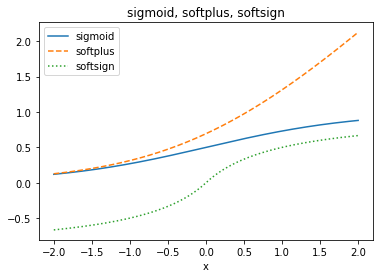

In [49]:
import matplotlib.pylab as plt
x = tf.linspace(-2.0, 2, 1000)
y1 = tf.nn.sigmoid(x)
y2 = tf.nn.softplus(x)
y3 = tf.nn.softsign(x)

plt.plot(x.eval(), y1.eval(), "-", label="sigmoid")
plt.plot(x.eval(), y2.eval(), "--", label="softplus")
plt.plot(x.eval(), y3.eval(), ":", label="softsign")
plt.xlabel("x")
plt.title("sigmoid, softplus, softsign")
plt.legend()
plt.show()

## 자동 형변환

TensorFlow 연산자에 NumPy 배열이 들어가면 자동으로 상수형 텐서 자료형으로 형변환(coercion)되어 연산이 이루어진다.

In [50]:
a = np.ones((2, 3), dtype=np.float32)
b = tf.ones([3, 1], dtype=tf.float32)
tf.matmul(a, b)

<tf.Tensor 'MatMul_1:0' shape=(2, 1) dtype=float32>

## 미분

TensorFlow 도 심볼릭 연산에 의한 미분 계산이 가능하다. 도함수를 만들 때는 `tf.gradients` 명령을 사용한다.

In [51]:
x = tf.Variable(2.0)
f = x ** 2
fx = tf.gradients(f, [x])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run(f))
    print(sess.run(fx))

4.0
[4.0]


## TensorFlow를 이용한 선형회귀

지금까지 배운 개념을 이용해 보스턴 주택가격을 예측하는 선형회귀모형을 구현해 보자.

In [53]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['const'] = np.ones(df.shape[0])
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,const
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,1.0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,1.0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,1.0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,1.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,1.0


In [54]:
n, m = df.shape

X = tf.placeholder(tf.float64, shape=(n, m))
y = tf.placeholder(tf.float64, shape=(n, 1))

XT = tf.transpose(X)
w = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
y_pred = tf.matmul(X, w)

with tf.Session() as sess:
    y_pred_ = sess.run(y_pred,
                       feed_dict={X: df.values, y: boston.target.reshape(-1, 1)})

print("예측한 집값 :", y_pred_[19], "실제 집값 :", boston.target[19])

예측한 집값 : [18.40613603] 실제 집값 : 18.2


## 퍼셉트론

이번엔 Iris 데이터 중 두 종류를 분류하는 퍼셉트론을 제작한다. y값은 1 또는 -1을 사용하고 활성화 함수로는 하이퍼탄젠트(hypertangent)함수를 사용한다.

In [69]:
from sklearn.datasets import load_iris

iris = load_iris()
idx = np.in1d(iris.target, [0, 2])
X_data = iris.data[idx, 0:2]
y_data = (iris.target[idx] - 1.0)[:, np.newaxis]  # y=1 또는 y=-1. 2차원임을 명시

## 최적화

TensorFlow에는 Theano와 달리 최적화를 위한 `GradientDescentOptimizer` 등의 클래스가 미리 구현되어 있으므로 사용자가 구현할 필요가 없다. 최적화 관련 클래스를 생성하고 `minimize`명령에 최소화 하고 싶은 값의 텐서를 입력하면 된다. 

In [71]:
tf.reset_default_graph()  # 지금까지 생성된 모든 텐서를 그래프에서 제거

np.random.seed(0)
with tf.variable_scope("perceptron", reuse=tf.AUTO_REUSE):
    w = 1e-3 * tf.get_variable("weight", [2, 1], dtype=tf.float64,
                               initializer=tf.random_uniform_initializer())
    b = 1e-3 * tf.get_variable("bias", [], dtype=tf.float64,
                               initializer=tf.random_uniform_initializer())
    z = tf.tanh(tf.matmul(X_data, w) + b)

zero = np.zeros(1, dtype=np.float64)[0]  # float64 자료형의 0 값 생성
cost = tf.reduce_sum(tf.maximum(zero, tf.multiply(-y_data, z)))
optimizer = tf.train.GradientDescentOptimizer(1e-1)
train = optimizer.minimize(cost)

Tensor("Sum:0", shape=(), dtype=float64)


## TensorBoard

TensorFlow는 모형 내부와 결과를 모니터링 할 수 있는 텐서보드(TensorBoard) 라는 웹서버를 제공한다.

텐서보드 웹서버는 포트 6006을 사용하므로 만약 도커를 사용하는 경우에는 다음과 같이 포트를 열고 실행해야 한다.

```
docker run --name rpython -it -p 8888:8888 -p 6006:6006 datascienceschool/rpython
```

### 텐서보드 용 로그 생성

TensorFlow 처리 과정에서 로그 파일을 만들면 추후 텐서보드 등의 프로그램에서 읽어서 웹 화면에 나타낼 뿐이다. 따라서 계산 코드에서 로그 생성을 위한 코드를 추가해 주어야 한다. 

로그 코드는 다음과 같은 순서로 추가한다.

1. `summary.scalar`(저장하려는 값이 스칼라 값일 때) 명령이나 `summary.histogram`(저장하려는 값이 다차원 값일 때) 명령으로 개별 변수 기록용 데이터 생성한다. 
2. `summary.merge_all` 명령으로 개별 변수 기록용 데이터를 하나로 합침. 일부만 합치고 싶다면 `summary.merge()`함수의 입력값으로 합치고 싶은  개별 변수 기록용 데이터를 리스트 형태로 입력하면된다. 
3. 세션 생성후 `tf.summary.FileWriter` 명령으로 기록용 객체 생성(다음 예제의 `writer`). 이 때 입력값으로 기록할 디렉토리를 설정한다.
4. `sess.run` 명령으로 합쳐진 변수 기록용 데이터(다음 예제의 `merged`)를 실행하면 기록.
5. 기록용 객체의 `add_summary` 명령으로 실행시킨 변수 기록용 데이터를 실제 파일에 쓰기.

방금 전 구현한 퍼셉트론 예제를 텐서보드용 로그를 생성하면서 실행한다. 여기에서는 `/home/dockeruser/logs/`라는 디렉토리에 로그를 저장한다. 기존의 로그 파일이 존재한다면 실행하기 전에 과거 로그를 삭제한다.

!rm -rf /home/dockeruser/logs/*

In [57]:
w_summary = tf.summary.histogram("w", w)
b_summary = tf.summary.scalar("b", b)
z_summary = tf.summary.histogram("z", z)
cost_summary = tf.summary.scalar("cost", cost)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
with tf.Session() as sess:
    writer = tf.summary.FileWriter("logs", sess.graph)
    sess.run(init)
    for i in range(200):
        if i % 10 == 0:
            _, cost_, summary = sess.run([train, cost, merged])
            print("{:4d} : {:.5f} ".format(i, cost_))
        else:
            _, summary = sess.run([train, merged])
        writer.add_summary(summary, i)
    y_pred = sess.run(tf.sign(z))

   0 : 0.17248 
  10 : 0.07796 
  20 : 0.01540 
  30 : 0.01215 
  40 : 0.00890 
  50 : 0.00568 
  60 : 0.00375 
  70 : 0.00153 
  80 : 0.00488 
  90 : 0.00105 
 100 : 0.00202 
 110 : 0.00143 
 120 : 0.00062 
 130 : 0.00006 
 140 : 0.00006 
 150 : 0.00006 
 160 : 0.00006 
 170 : 0.00006 
 180 : 0.00006 
 190 : 0.00006 


In [58]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_data, y_pred)

array([[49,  1],
       [ 1, 49]], dtype=int64)

### 텐서보드 가동

텐서보드를 가동하기 위해서는 콘솔에서 다음과 같이 ip 주소와 로그 디렉토리를 설정하여 실행한다.

```
$ tensorboard --host=127.0.0.1 --logdir=C:\workspace\myproject\mytasks\mytask5h_for_Jupyter_notebook\logs
```

위와 같이 실행한 다음에는 다음 주소로 연결하면 텐서보드 화면을 볼 수 있다.

- http://localhost:6006

도커 환경을 사용하는 경우에는

- http://192.168.99.100:6006 

<img src="https://datascienceschool.net/upfiles/1e9a73b99c68480d8a4e2c64c0d0ecac.png" style="width:100%;">

그림 54.8: 텐서보드 실행 화면

텐서보드는 정의한 그래프를 시각화해주는 기능도 있다. 상단 메뉴의 "GRAPHS"를 클릭하면 다음처럼 우리가 정의한 모형의 그래프 구조를 시각화하여 확인 할 수 있다.

<img src="https://datascienceschool.net/upfiles/415ee6834f4b489b85074862b7479f48.png" style="width:100%;">

그림 54.9: 텐서보드의 그래프 시각화 화면

#### 연습 문제 1

위 퍼셉트론 코드를 다음과 같이 고쳐라.

1. y값은 0과 1이라는 값만 가진다.
2. 활성화 함수는 로지스틱 함수를 사용한다.
3. 코스트 함수는 다음과 같은 오차 제곱 합수를 사용한다.

$$ C = \sum_{i=1}^N (y - \hat{y})^2 $$